In [1]:
import sys
import os
#import torch
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

#from torch import nn
from pathlib import Path
from scipy.stats import linregress
from typing import Union
from sklearn.model_selection import cross_val_predict

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath, prep_and_resample
from Medley.utils import data_for_pcolormesh, udomains, regions
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample,remove_bottleneck
from Medley.crossval import SpatiotemporalSplit
from Medley.estimators import return_estimator

In [2]:
warnings.simplefilter('ignore',category=RuntimeWarning)
warnings.simplefilter('ignore',category=UserWarning)

## Timeseries
Length, data source, literature, directionality

In [28]:
preds = get_monthly_data()
# Red is drying, blue is wettening, grey = unknown.
directionality = pd.Series(['blue','blue','blue','blue', #enso 12, 3,34,4
                            'grey','grey', # amo
                            'blue', # amoc
                            'red','red', # nao
                            'red', # snao
                            'red','red', # ao
                            'blue', # east atl
                            'grey', # pdo
                            'red', # gmst
                            'red','blue', # mjo3, mjo6
                            'grey', # qbo
                            'red','red','grey','blue','grey','grey', # med250 latmax, 20,30,40,50,60 
                            'grey','grey','grey','grey','grey','grey', # atl250 latmax, 20,30,40,50,60 
                            'grey','red','blue','grey','grey','red', # med500 latmax, 20,30,40,50,60 
                            'red','blue','grey','grey','red','red', # atl500 latmax, 20,30,40,50,60 
                            'red', # vortex
                            'grey','grey','grey','grey','grey','grey', # atleke latmax, 20,30,40,50,60 
                            'grey','red','red', # iod, west ind, east ind.
                           ],index = preds.columns)

In [29]:
valid = ~preds.isnull()
for i, col in enumerate(valid.columns):
    valid.loc[:,col] = np.where(valid.loc[:,col], i, np.nan)


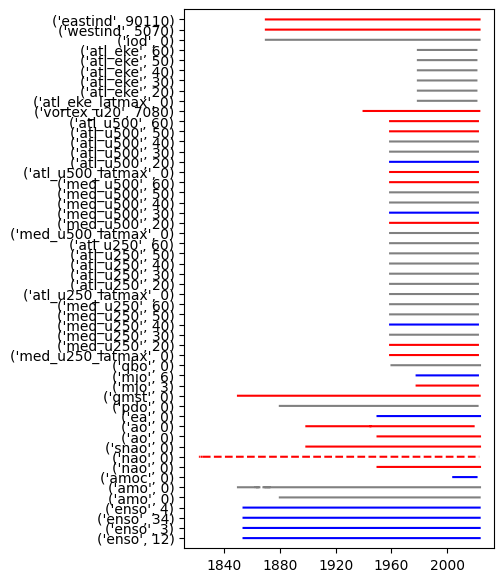

In [39]:
fig, ax = plt.subplots(figsize = (4,7))
for col in valid.columns:
    if 'station' in col:
        sty = 'dashed'
    else:
        sty = 'solid'
    ax.plot(valid.index, valid.loc[:,col], ls = sty, color = directionality.loc[col])
#valid.plot(color = 'grey', ax = ax, legend = False)
ax.set_ylim(-1,len(valid.columns))
ax.set_yticks(np.arange(0,len(valid.columns)))
ax.set_yticklabels(valid.columns.droplevel(-1).to_flat_index())
plt.show()

## Regions

In [3]:
regions['west']

{'include': {'iberia': (-9.8, 35.98, 3.6, 43.8),
  'france_italy': (4, 43, 13.4, 45.63)},
 'exclude': {'islands': (0.79, 35.2, 4.6, 40.4),
  'north_africa': (-1.45, 34.457, 11.217, 36.972)}}